Generation of 1-Shot Examples and 2-Shots examples :

In [62]:
import random

def generate_X_shot_prompt(df, nm_shot):
    """ Build a few shot prompt."""
    # build the list of prompts
    prompts = ''

    for _ in range(nm_shot):
        index_random = random.randint(0, len(df) - 1)  # This will generate a random integer between 0 and len(df) - 1
        prompts += '#' + df.iloc[index_random]['text'] + '\n' + df.iloc[index_random]['code'] + '\n\n'

    return prompts

def generate_X_shot(Oneshot, df_test, path_to_save, nm_shot):
    """ Generate few shot prompt for a dataset. """

    # Add it to the data
    for i in range(len(df_test)):
        instruction = df_test.iloc[i]['instruction']
        df_test.at[i,'instruction'] = Oneshot + instruction
    
    df_test.to_csv(f"{path_to_save}/mbpp_test_100_{nm_shot}Shot.csv", index=False )

    return None

In [73]:
prompt = pd.read_csv('data/MBPP/mbpp_prompt.csv')
test = pd.read_csv('data/MBPP/mbpp_test_100.csv')
path_to_save = 'data/MBPP/'

Onehsot= 'R = 3\nC = 3\ndef min_cost(cost, m, n):\n\t""" #Write a function to find the minimum cost path to reach (m, n) from (0, 0) for the given cost matrix cost[][] and a position (m, n) in cost[][]"""\n\ttc = [[0 for x in range(C)] for x in range(R)]\n\ttc[0][0] = cost[0][0]\n\tfor i in range(1, m+1):\n\t\ttc[i][0] = tc[i-1][0] + cost[i][0]\n\tfor j in range(1, n+1):\n\t\ttc[0][j] = tc[0][j-1] + cost[0][j]\n\tfor i in range(1, m+1):\n\t\tfor j in range(1, n+1):\n\t\t\ttc[i][j] = min(tc[i-1][j-1], tc[i-1][j], tc[i][j-1]) + cost[i][j]\n\treturn tc[m][n]\n\n'
Twoshots = 'import heapq as hq\ndef heap_queue_largest(nums,n):\n\t"""Write a function to find the largest integers from a given list of numbers using heap queue algorithm."""\n\tlargest_nums = hq.nlargest(n, nums)\n\treturn largest_nums\n\ndef square_nums(nums):\n\t"""Write a function to find squares of individual elements in a list using lambda function."""\n\tsquare_nums = list(map(lambda x: x ** 2, nums))\n\treturn square_nums\n\n'

generate_X_shot(Twoshots,test,path_to_save,2)

<h1>Exploration of the output</h1>

In [1]:
import pandas as pd

mbpp_generated = pd.read_csv('data/MBPP/Generated/mbpp_test_200_sampling.csv')

In [2]:
import ast

def generate_length_list(dataset):

    listOfListOfLength = []

    for i in range(len(dataset)):
        listOfLenght = []
        len_prompt = len(dataset.iloc[i]['text'])
        listOfGeneratedCode = ast.literal_eval(dataset.iloc[i]['generated_code'])
        for _ in range(len(listOfGeneratedCode)):
            listOfLenght.append(len(listOfGeneratedCode) - (4 + len_prompt + 3))
        
        listOfListOfLength.append(listOfLenght)
    
    return listOfListOfLength

def extract_reference(dataset):

    reference = []

    for i in range(len(dataset)):
        reference.append(len(dataset.iloc[i]['code']))

    return reference

listOfListOfLength = generate_length_list(mbpp_generated)
reference = extract_reference(mbpp_generated)

In [31]:
absolute_errors = []
for i, inner_list in enumerate(listOfListOfLength):
    error = [abs(val - reference[i]) for val in inner_list]
    absolute_errors.append(error)

In [32]:
mae = [sum(error)/len(error) for error in absolute_errors]

In [33]:
import numpy as np
std_errors = [np.std(error) for error in absolute_errors]

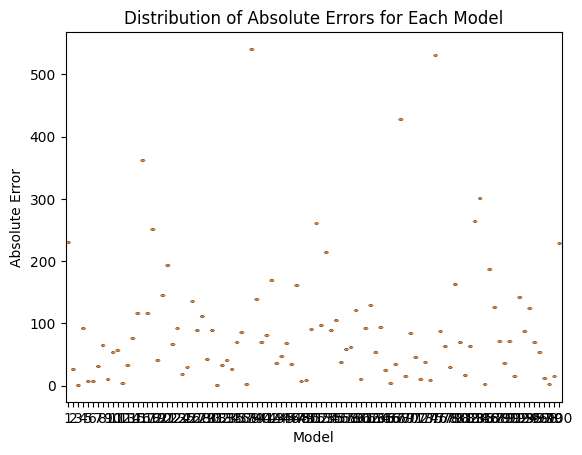

In [34]:
import matplotlib.pyplot as plt

plt.boxplot(absolute_errors)
plt.title('Distribution of Absolute Errors for Each Model')
plt.xlabel('Model')
plt.ylabel('Absolute Error')
plt.show()

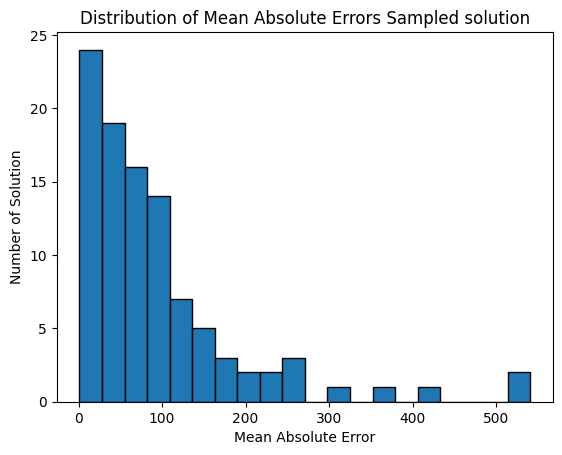

In [37]:
plt.hist(mae, bins=20, edgecolor='black')
plt.title('Distribution of Mean Absolute Errors Sampled solution')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Number of Solution')
plt.show()

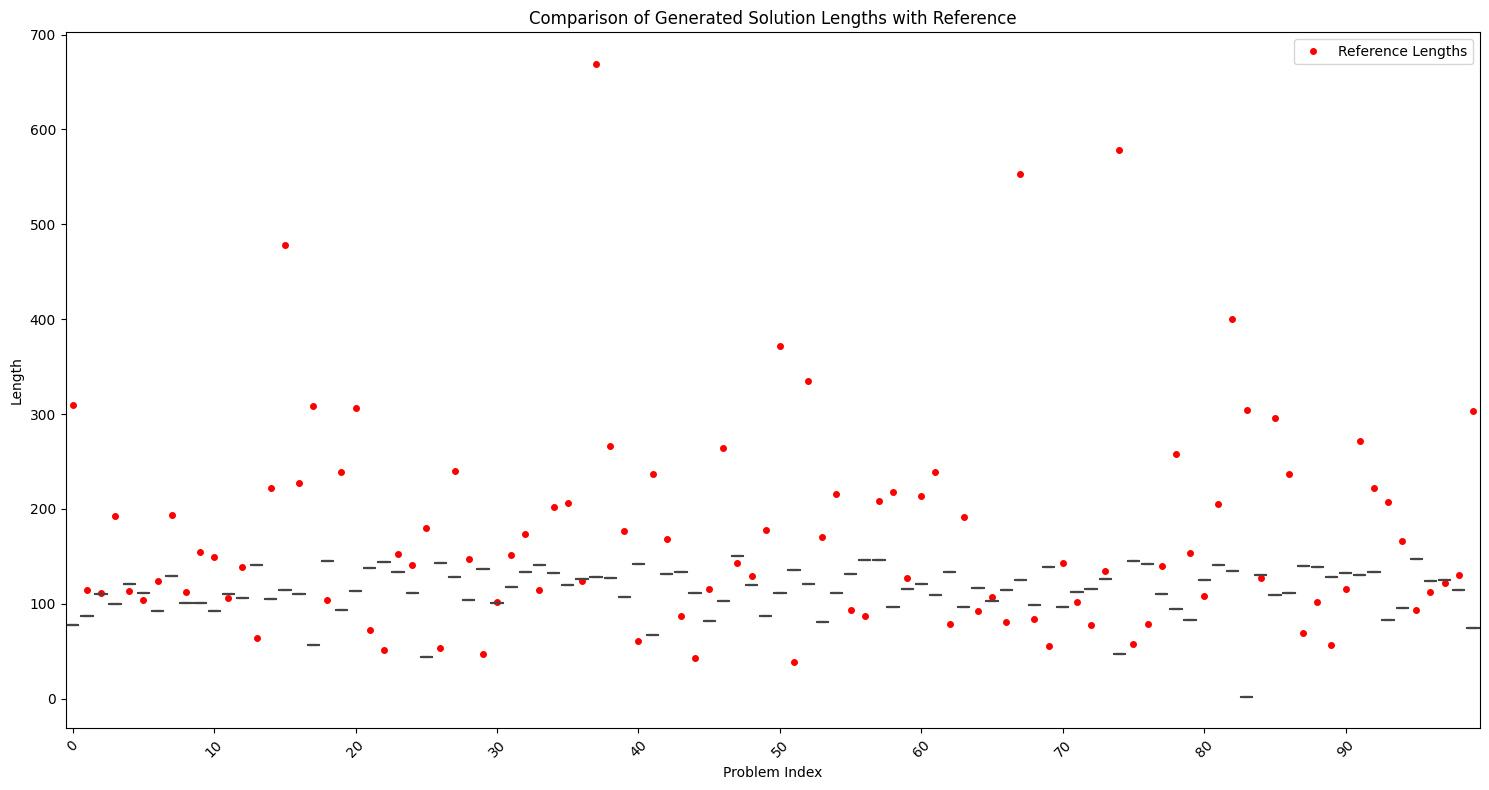

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

listOfListOfLength = generate_length_list(mbpp_generated)
reference = extract_reference(mbpp_generated)

# Assume `data` is your list of lists, and `reference` is the list of reference lengths
data_transposed = list(zip(*listOfListOfLength))
df = pd.DataFrame(data_transposed)

# Plotting
plt.figure(figsize=(15, 8))
sns.boxplot(data=df)

# Display every 10th label
ticks = plt.xticks()[0]
plt.xticks(ticks[::10], [str(int(tick)) for tick in ticks][::10], rotation=45)

plt.plot(reference, 'ro', markersize=4, label="Reference Lengths")
plt.legend()
plt.title("Comparison of Generated Solution Lengths with Reference")
plt.ylabel("Length")
plt.xlabel("Problem Index")
plt.tight_layout()

# Save the figure
plt.savefig("ComparisonGeneratedSolutionByLength.png", dpi=300, bbox_inches="tight")

plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_absolute_errors(generated_lengths, reference_length):
    return [abs(length - reference_length) for length in generated_lengths]

def calculate_mae_for_problem(absolute_errors):
    return np.mean(absolute_errors)

def calculate_std_for_problem(absolute_errors):
    return np.std(absolute_errors)

def global_mae(data, references):
    all_errors = [calculate_absolute_errors(data[i], references[i]) for i in range(len(data))]
    all_maes = [calculate_mae_for_problem(errors) for errors in all_errors]
    return np.mean(all_maes)

def global_std(data, references):
    all_errors = [calculate_absolute_errors(data[i], references[i]) for i in range(len(data))]
    return np.std([error for sublist in all_errors for error in sublist])

In [47]:
def plot_boxplots(data, references):
    all_errors = [calculate_absolute_errors(data[i], references[i]) for i in range(len(data))]
    plt.boxplot(all_errors)
    plt.xlabel('Problem')
    plt.ylabel('Absolute Error')
    plt.title('Boxplots of Absolute Errors for Each Problem')
    plt.show()

def plot_mae_histogram(data, references):
    all_errors = [calculate_absolute_errors(data[i], references[i]) for i in range(len(data))]
    maes = [calculate_mae_for_problem(errors) for errors in all_errors]
    plt.hist(maes, bins=20)
    plt.xlabel('Mean Absolute Error')
    plt.ylabel('Number of Problems')
    plt.title('Histogram of MAEs for All Problems')
    plt.show()

def plot_reference_vs_mae_scatter(data, references):
    all_errors = [calculate_absolute_errors(data[i], references[i]) for i in range(len(data))]
    maes = [calculate_mae_for_problem(errors) for errors in all_errors]
    plt.scatter(references, maes)
    plt.xlabel('Reference Length')
    plt.ylabel('Mean Absolute Error')
    plt.title('Reference Length vs. MAE for Each Problem')
    plt.show()

In [ ]:
listOfListOfLength = generate_length_list(mbpp_generated)
references = extract_reference(mbpp_generated)

# Calculate Global MAE and Std
global_mean_absolute_error = global_mae(listOfListOfLength, references)
global_standard_deviation = global_std(listOfListOfLength, references)

print("Global Mean Absolute Error:", global_mean_absolute_error)
print("Global Standard Deviation of Errors:", global_standard_deviation)

# Generate the described visualizations:
plot_reference_vs_mae_scatter(listOfListOfLength, references)

In [51]:
def plot_reference_vs_mae_scatter(data, references):
    # Setting up a high-quality figure with a white background
    plt.figure(figsize=(10, 6), dpi=150)
    
    # Calculating the necessary values
    all_errors = [calculate_absolute_errors(data[i], references[i]) for i in range(len(data))]
    maes = [calculate_mae_for_problem(errors) for errors in all_errors]
    
    # Creating the scatter plot
    plt.scatter(references, maes, color='dodgerblue', edgecolor='k', s=50, alpha=0.7)
    
    # Setting up the labels, title, and grid
    plt.xlabel('Reference Length', fontsize=14, fontweight='bold')
    plt.ylabel('Mean Absolute Error', fontsize=14, fontweight='bold')
    plt.title('Reference Length vs. MAE for Each Problem', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Using tight layout to ensure no element is cut off
    plt.tight_layout()
    
    # Display the figure
    plt.show()

In [ ]:
plot_reference_vs_mae_scatter(listOfListOfLength, references)

In [53]:
def plot_comparison_generated_solution_lengths(data, references):
    # Setting up a high-quality figure with a white background
    plt.figure(figsize=(10, 6), dpi=150)
    
    # Creating the boxplot with seaborn
    sns.boxplot(data=data, palette="Blues", boxprops=dict(alpha=0.7))
    
    # Setting up the labels, title, and grid
    plt.title('Comparison of Generated Solution Lengths with Reference', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Problem Index', fontsize=14, fontweight='bold')
    plt.ylabel('Length', fontsize=14, fontweight='bold')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Display every 10th label for legibility
    ticks = plt.xticks()[0]
    plt.xticks(ticks[::10], [str(int(tick)) for tick in ticks][::10], rotation=45, fontsize=12)
    
    # Plot the reference lengths
    plt.plot(references, 'ro', markersize=4, label="Reference Lengths")
    plt.legend(fontsize=12)
    
    # Ensure layout is tight so no element is cut off
    plt.tight_layout()
    
    # Save the figure in high resolution
    plt.savefig("ComparisonGeneratedSolutionByLength.png", dpi=300, bbox_inches="tight")
    
    # Display the plot
    plt.show()

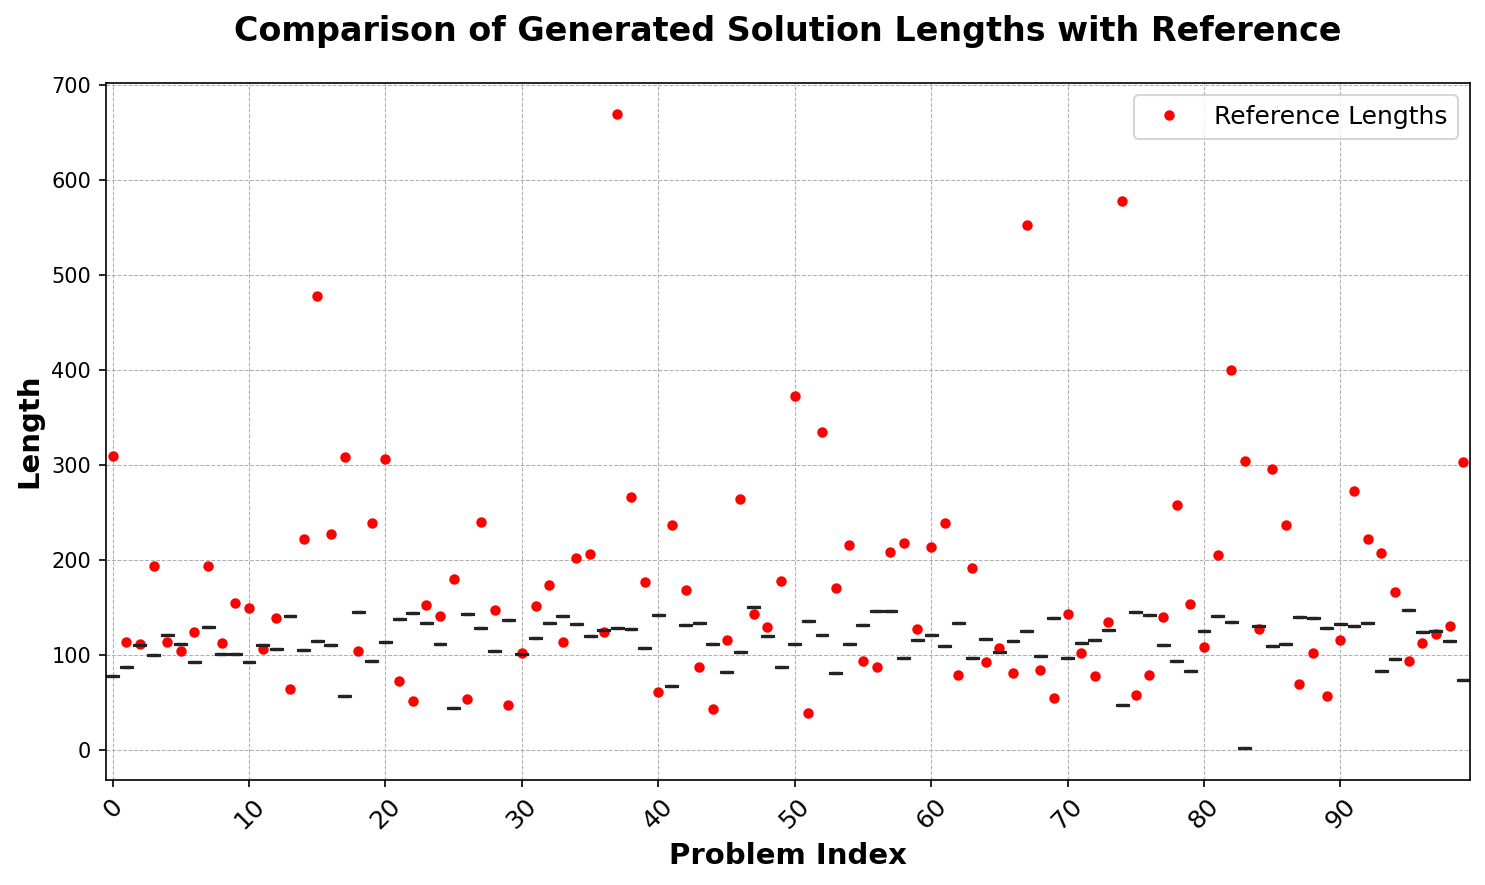

In [54]:
plot_comparison_generated_solution_lengths(listOfListOfLength, references)

In [5]:
# Hypothesis testing:

import numpy as np
from scipy.stats import ttest_rel

listOfListOfLength = generate_length_list(mbpp_generated)
references = extract_reference(mbpp_generated)

# Calculate Global MAE and Std
global_mean_absolute_error = global_mae(listOfListOfLength, references)
global_standard_deviation = global_std(listOfListOfLength, references)

print("Global Mean Absolute Error:", global_mean_absolute_error)
print("Global Standard Deviation of Errors:", global_standard_deviation)

# Calculate average lengths of generated solutions for each problem
mean_lengths = [np.mean(sol_lengths) for sol_lengths in listOfListOfLength]

# Conduct the paired t-test
t_statistic, p_value = ttest_rel(mean_lengths, references)

# Check if the model tends to generate longer code than the reference
if p_value/2 < 0.05 and t_statistic > 0:  # We divide p_value by 2 for a one-tailed test
    print("There is statistically significant evidence that the model generates longer code than the reference.")
else:
    print("There isn't enough evidence to conclude that the model generates longer code than the reference.")

Global Mean Absolute Error: 92.84
Global Standard Deviation of Errors: 101.71988202903108
There isn't enough evidence to conclude that the model generates longer code than the reference.


In [6]:
def calculate_mean(reference, mean_lengths):
    mean_ref = sum(reference) / len(reference)
    mean_length = sum(mean_lengths) / len(reference)
    return mean_ref,mean_length

In [7]:
mean_ref,mean_length = calculate_mean(references, mean_lengths) 

In [8]:
mean_ref,mean_length

(174.97, 114.05)

In [9]:
import scipy.stats as stats

def test_normality(data):
    """
    Conduct the Shapiro-Wilk test for normality.
    
    Args:
    - data (list or np.array): The data points.

    Returns:
    - W (float): Test statistic.
    - p_value (float): p-value of the test.
    """
    W, p_value = stats.shapiro(data)
    return W, p_value

In [13]:
W,p = test_normality(mean_lengths)
W,p
alpha = 0.05  # Common significance level
if p> alpha:
    print(f"The data seems to be normally distributed (W={W:.4f}, p={p:.4f}).")
else:
    print(f"The data does not seem to be normally distributed (W={W:.4f}, p={p:.4f}).")

The data does not seem to be normally distributed (W=0.9063, p=0.0000).


In [14]:
import numpy as np

def bootstrap_ci(data, num_samples=10000, alpha=0.05):
    """
    Calculate a bootstrapped confidence interval for the mean of the data.
    
    Args:
    - data (list or np.array): The data points.
    - num_samples (int): Number of bootstrap samples to generate.
    - alpha (float): Significance level (e.g., 0.05 for a 95% CI).

    Returns:
    - (tuple): Lower and upper bounds of the confidence interval.
    """
    means = np.empty(num_samples)
    
    for i in range(num_samples):
        sample = np.random.choice(data, len(data), replace=True)
        means[i] = sample.mean()
        
    lower = np.percentile(means, 100 * (alpha / 2))
    upper = np.percentile(means, 100 * (1 - alpha / 2))
    
    return lower, upper

In [17]:
lower, upper = bootstrap_ci(mean_lengths)

In [18]:
lower, upper

(109.08, 118.67)

In [22]:
import numpy as np
from scipy.stats import ttest_1samp

def one_sample_ttest_per_problem(data, reference):
    """ 
        1 stand for longer, -1 stand for shorter and 0 is that there isn't enought evidence """
    results = []

    for i, sol_lengths in enumerate(data):
        t_statistic, p_value = ttest_1samp(sol_lengths, reference[i])
        if p_value < 0.05:
            if np.mean(sol_lengths) > reference[i]:
                results.append(1)
            else:
                results.append(-1)
        else:
            results.append(0)

    return results

listOfListOfLength = generate_length_list(mbpp_generated)
references = extract_reference(mbpp_generated)

# Sample usage
results = one_sample_ttest_per_problem(listOfListOfLength, references)

c:\Users\mariu\anaconda3\envs\comp0197-pt\lib\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [25]:
num_one, num_min, num_zero = 0,0,0
for element in results:
    if element == 1:
        num_one+=1
    elif element == -1:
        num_min+=1
    else: 
        num_zero+=1

In [26]:
num_one, num_min, num_zero

(36, 64, 0)

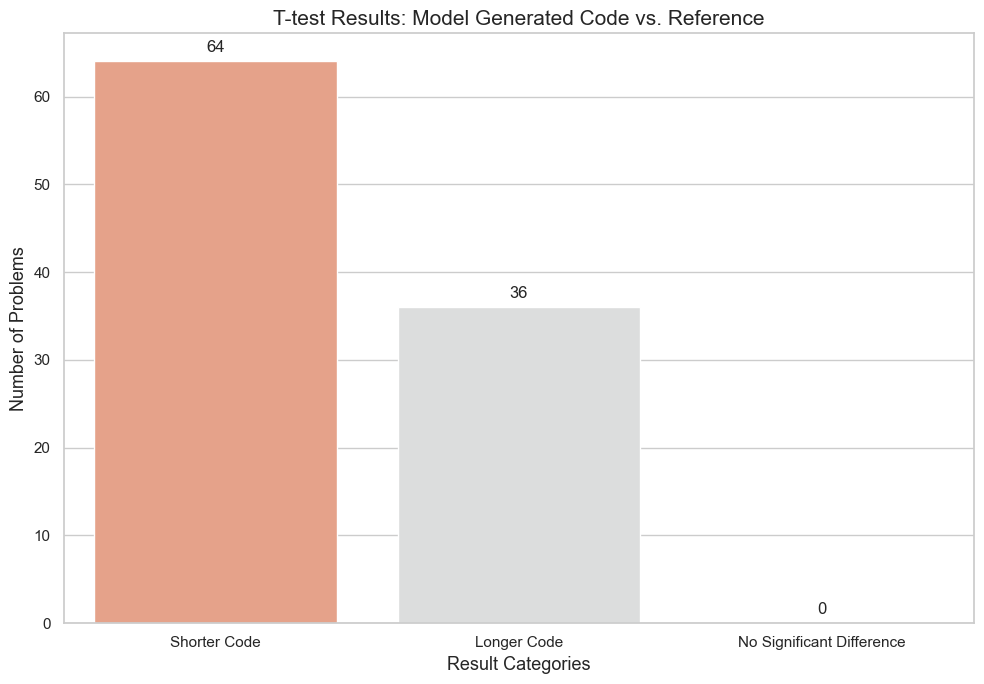

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ttest_results(shorter, longer, no_difference):
    """Plot results from one-sample t-test."""
    sns.set(style="whitegrid")
    
    # Values
    categories = ['Shorter Code', 'Longer Code', 'No Significant Difference']
    values = [shorter, longer, no_difference]
    
    # Create the bar chart
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=categories, y=values, palette="coolwarm_r")

    # Add annotations on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=12)
        
    plt.title('T-test Results: Model Generated Code vs. Reference', fontsize=15)
    plt.ylabel('Number of Problems', fontsize=13)
    plt.xlabel('Result Categories', fontsize=13)
    plt.tight_layout()
    
    # Save the figure with high dpi
    plt.savefig("TTestResultsComparison.png", dpi=300, bbox_inches="tight")

    plt.show()

# Sample usage
plot_ttest_results(64, 36, 0)

In [28]:
from scipy.stats import binom_test

# Number of problems where the model generates significantly longer solutions
observed_successes = 64

# Total number of problems
n = 100

# Conduct the binomial test
p_value = binom_test(observed_successes, n, 0.5, alternative='greater')

if p_value < 0.05:
    print(f"With a p-value of {p_value:.4f}, we reject the null hypothesis. There's significant evidence that the model has a tendency to generate longer solutions than the reference.")
else:
    print("There's no significant evidence to suggest the model consistently generates longer solutions.")

With a p-value of 0.0033, we reject the null hypothesis. There's significant evidence that the model has a tendency to generate longer solutions than the reference.


C:\Users\mariu\AppData\Local\Temp\ipykernel_49072\23505468.py:10: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = binom_test(observed_successes, n, 0.5, alternative='greater')


In [2]:
# format for testing
#candidate = [[df.iloc[i]['process_Gen_code']]]
#test = ast.literal_eval(df.iloc[i]['processed_tests'])

import pandas as pd
import numpy as np
import ast

mbpp_sampling_200 = pd.read_csv('data/MBPP/Generated/mbpp_test_200_sampling.csv')
mbpp_greedy = pd.read_csv('data/MBPP/Generated/mbpp_test_greedy.csv')
mbpp_oneShot = pd.read_csv('data/MBPP/Generated/mbpp_test_greedy_OneShot.csv')
mbpp_twoShot = pd.read_csv('data/MBPP/Generated/mbpp_test_greedy_TwoShot.csv')


def extract_assertions(input_string):
    """ Transform the assertions to be as a list """
    # Using ast.literal_eval to safely parse the string representation of list into an actual list
    extracted_list = ast.literal_eval(input_string)
    
    # Now, ast.literal_eval gives us list of single string, we need to split this string 
    # into individual assertions. We will use newline '\n ' as the separator
    assertions = extracted_list[0].split('\n ')
    
    # Strip leading and trailing white spaces from each assertion
    # Also strip leading and trailing escape characters and quotation marks
    assertions = [assertion.strip().strip('\'') for assertion in assertions]
    
    # string of assertions
    str_assertions = assertions[0].split('assert')
    processed_assertions = []
    
    for i in range(len(str_assertions) - 1):
        processed_assertions.append('assert' + str_assertions[i+1])

    return processed_assertions

def process_assertions(df):
    list_assertions = []
    for i in range(len(df)):
        assertions = np.array(df.iloc[i]['test_list']).tolist()  # Convert NumPy array to Python list
        list_assertions.append(extract_assertions(assertions))

    df['tests'] = list_assertions
    return df

def processing_mbpp(df, is_test):
    """ Process both instruction and test_list"""
    # df = preprocessing_instruction(df)
    if is_test == True:
        df = process_assertions(df)
    return df

def extract_function(text):
    list_blocks = text.split('def')
    generated = list_blocks[3]
    gen_code = 'def'+generated
    return gen_code

def process_oneShot(data):
    """ Only keep the generated function."""
    generated_code = []
    for i in range(len(data)):
        generated_code.append(extract_function(ast.literal_eval(data.iloc[i]['generated_code'])[0]))
    
    data['generated_code'] = generated_code
    return data

def transform_string(code_str):
    return repr(code_str)

def transform_string_datafram(data):
    generated_code = []
    for i in range(len(data)):
        code = transform_string(data.iloc[i]['generated_code'])
        generated_code.append('['+code+']')

    data['generated_code'] = generated_code

    return data

<h1>Evaluate results<h1>

In [33]:
import pandas as pd
import ast

report_Sampling = pd.read_csv('data/MBPP/report/reports_mbpp_test_200_sampling_Testing.csv')
report_greedy = pd.read_csv('data/MBPP/report/reports_mbpp_test_greedy.csv')
report_oneshot = pd.read_csv('data/MBPP/report/reports_mbpp_test_greedy_OneShot_Processed.csv')
report_twoshot = pd.read_csv('data/MBPP/report/reports_mbpp_test_greedy_TwoShot_Processed.csv')

In [168]:
def pass_k_report(data):
    pass_k = {
    'pass1':[],
    'pass10':[],
    'pass100':[]
    }

    for i in range(len(data)):

        pass10 = ast.literal_eval(data.iloc[i]['Pass_ten'])
        pass100 = ast.literal_eval(data.iloc[i]['Pass_Hundread'])
        pass1 = ast.literal_eval(data.iloc[i]['Pass_one'])

        pass_k['pass1'].append(pass1)
        pass_k['pass10'].append(pass10)
        pass_k['pass100'].append(pass100)

    return pass_k

In [170]:
def pass_1_report(data):
    pass_1 = {
    'pass1':[]
    }

    for i in range(len(data)):

        pass1 = ast.literal_eval(data.iloc[i]['Pass_one'])

        pass_1['pass1'].append(pass1)

    return pass_1

In [121]:
import ast
from collections import defaultdict
import re


def parse_tuple_str(s):
    # Find all items within () and treat them as tuples
    tuple_strings = re.findall(r'\(([^)]+)\)', s)
    
    tuples = []
    for tuple_str in tuple_strings:
        # Handle nested structures manually
        if tuple_str.count("{") != tuple_str.count("}"):
            # Extract the nested dictionary
            nested_dict_str = re.search(r'\{[^}]+\}', tuple_str).group(0)
            nested_dict = ast.literal_eval(nested_dict_str)
            
            # Replace the nested dict in the tuple_str and reformat
            tuple_str = tuple_str.replace(nested_dict_str, '').split(',')
            tuple_items = [int(tuple_str[0])] + [nested_dict]
            
            tuples.append(tuple(tuple_items))
        else:
            tuples.append(ast.literal_eval(f"({tuple_str})"))
    
    return tuples

def parse_defaultdict_str(s):
    # Split by "defaultdict(, " and process each part
    parts = s.split("defaultdict(, ")[1:]
    
    dicts = []
    for part in parts:
        dict_str = re.search(r'\{[^}]+\}', part).group(0)
        d = ast.literal_eval(dict_str)
        
        # For the values that are lists of tuples with nested dicts
        # replace with parsed values
        for key, value in d.items():
            d[key] = parse_tuple_str(value[0])
        dicts.append(d)
    
    return dicts

def convert_to_dict(input_str):
    list_of_dicts = parse_defaultdict_str(input_str)
    
    result = {}
    for idx, d in enumerate(list_of_dicts):
        result[idx] = d

    return result


Sampling

In [169]:
pass_k = pass_k_report(report_Sampling)
averages = {}

for metric, problems in pass_k.items():
    problem_averages = [sum(p) / len(p) for p in problems]
    averages[metric] = sum(problem_averages) / len(problem_averages)

print(averages)

{'pass1': 0.2395333333333333, 'pass10': 0.5022098014174748, 'pass100': 0.6846559573371386}


In [ ]:
Greedy

In [171]:
pass_k = pass_1_report(report_greedy)
averages = {}

for metric, problems in pass_k.items():
    problem_averages = [sum(p) / len(p) for p in problems]
    averages[metric] = sum(problem_averages) / len(problem_averages)

print(averages)

{'pass1': 0.27}


In [172]:
pass_1 = pass_1_report(report_oneshot)
averages = {}

for metric, problems in pass_k.items():
    problem_averages = [sum(p) / len(p) for p in problems]
    averages[metric] = sum(problem_averages) / len(problem_averages)

print(averages)

{'pass1': 0.27}


In [173]:
pass_1 = pass_1_report(report_twoshot)
averages = {}

for metric, problems in pass_k.items():
    problem_averages = [sum(p) / len(p) for p in problems]
    averages[metric] = sum(problem_averages) / len(problem_averages)

print(averages)

{'pass1': 0.27}


<h1>CodeBLEU evaluation<h1>

In [11]:
import pandas as pd
sampling_data = pd.read_csv('data/MBPP/Generated/mbpp_test_200_sampling_Testing.csv')
greedy_data = pd.read_csv('data/MBPP/Generated/mbpp_test_greedy.csv')

In [12]:
greedy_data.iloc[0]['generated_code']

'[\'def no_of_subsequences(arr, k):\\n\\t"""Write a function to find the number of subsequences having product smaller than k for the given non negative array."""\\n\\tn = len(arr)\\n\\tdp = [[0 for _ in range(n)] for _ in range(n)]\\n\\tfor i in range(n):\\n\\t\\tdp[i][i] = 1\\n\\tfor i in range(n):\\n\\t\\tfor j in range(i):\\n\\t\\t\\tif arr[i] * arr[j] < k:\\n\\t\\t\\t\\tdp[i][j] = dp[i][j - 1]\\n\\t\\t\\telse:\\n\\t\\t\\t\\tdp[i][j] = dp[i - 1][j] + dp[i][j -\']'

In [10]:
import ast
predictions = ast.literal_eval(sampling_data.iloc[0]['generated_code'])
predictions[0]

'def no_of_subsequences(arr, k):\n\t"""Write a function to find the number of subsequences having product smaller than k for the given non negative array."""\n\tn = len(arr)\n\tif k <= 1:\n\t\treturn 0\n\tsubsequence_count = [0] * (n + 1)\n\tfor i in range(1, n + 1):\n\t\tfor j in range(i):\n\t\t\tif arr[i - 1] < arr[j]:\n\t\t\t\tsubsequence_count[i] += subsequence_count[j]\n\treturn subsequence_count[n]'

In [ ]:
import ast
from codebleu import calc_codebleu

def calculate_mean(numbers):
    return sum(numbers) / len(numbers)

def remove_second_line(text):
    lines = text.split('\n')
    if len(lines) > 1:
        lines.pop(1)
    return '\n'.join(lines)

def code_BLEU_evaluation_Sampling(data):

    codeBLEU_scores = []
    n_gram_scores = []
    weighted_n_gram_scores = []
    syntax_scores = []
    dataflow_match_scores = []

    for i in range(len(data)):

        reference = data.iloc[i]['code']
        predictions = ast.literal_eval(data.iloc[i]['generated_code'])

        codeBLEU_score = []
        n_gram_score = []
        weighted_n_gram_score = []
        syntax_score = []
        dataflow_match_score = []

        for prediction in predictions:

            generated_code = remove_second_line(prediction)
            result = calc_codebleu([reference], [generated_code], lang="python", weights=(0.25, 0.25, 0.25, 0.25), tokenizer=None)
            
            codeBLEU_score.append(result['codebleu'])
            n_gram_score.append(result['ngram_match_score'])
            weighted_n_gram_score.append(result['weighted_ngram_match_score'])
            syntax_score.append(result['syntax_match_score'])
            dataflow_match_score.append(result['dataflow_match_score'])
        
        codeBLEU_scores.append(calculate_mean(codeBLEU_score))
        n_gram_scores.append(calculate_mean(n_gram_score))
        weighted_n_gram_scores.append(calculate_mean(weighted_n_gram_score))
        syntax_scores.append(calculate_mean(syntax_score))
        dataflow_match_scores.append(calculate_mean(dataflow_match_score))

    
    return codeBLEU_scores, n_gram_scores,weighted_n_gram_scores, syntax_scores, dataflow_match_scores


def code_BLEU_evaluation_Greedy(data):
 
    codeBLEU_scores = []
    n_gram_scores = []
    weighted_n_gram_scores = []
    syntax_scores = []
    dataflow_match_scores = []

    for i in range(len(data)):

        reference = data.iloc[i]['code']
        prediction = ast.literal_eval(data.iloc[i]['generated_code'])[0]
        generated_code = remove_second_line(prediction)
        result = calc_codebleu([reference], [generated_code], lang="python", weights=(0.25, 0.25, 0.25, 0.25), tokenizer=None)
        
        codeBLEU_scores.append(result['codebleu'])
        n_gram_scores.append(result['ngram_match_score'])
        weighted_n_gram_scores.append(result['weighted_ngram_match_score'])
        syntax_scores.append(result['syntax_match_score'])
        dataflow_match_scores.append(result['dataflow_match_score'])
    
    return codeBLEU_scores, n_gram_scores,weighted_n_gram_scores, syntax_scores, dataflow_match_scores


In [22]:
# exploration of CodeBLEU scores

codeBLEU_Sampling = pd.read_csv('data/MBPP/CodeBLEU/codeBLEU_mbpp_test_200_sampling_Testing.csv')
codeBLEU_Greedy = pd.read_csv('data/MBPP/CodeBLEU/codeBLEU_mbpp_test_greedy.csv')
codeBLEU_OneShot = pd.read_csv('data/MBPP/CodeBLEU/codeBLEU_mbpp_test_greedy_OneShot_Processed.csv')
codeBLEU_TwoShot = pd.read_csv('data/MBPP/CodeBLEU/codeBLEU_mbpp_test_greedy_TwoShot_Processed.csv')

In [31]:
def everage_each_components(data):

    average_nGram = 0
    average_WeightednGram = 0
    average_syntax = 0
    average_Dataflow = 0

    for k in range(len(data)):
        nGram = ast.literal_eval(data.iloc[k]['nGramMatch'])[0]
        weightednGram = ast.literal_eval(data.iloc[k]['weightednGramMatch'])[0]
        syntax = ast.literal_eval(data.iloc[k]['syntaxScore'])[0]
        dataFlow = ast.literal_eval(data.iloc[k]['dataflowMatchScore'])[0]

        average_nGram+=nGram
        average_WeightednGram+=weightednGram
        average_syntax+=syntax
        average_Dataflow+=dataFlow
    
    return average_nGram / len(data), average_WeightednGram / len(data), average_syntax/len(data), average_Dataflow/len(data)


In [32]:
# Greedy Zero
average_nGram, average_WeightednGram, average_syntax, average_Dataflow = everage_each_components(codeBLEU_Greedy)
print('nGram',average_nGram, 'Weight', average_WeightednGram, 'Syntax',average_syntax,'Dataflow',average_Dataflow)

nGram 0.06448842286138613 Weight 0.08502761507187973 Syntax 0.22365007724321154 Dataflow 0.4408654352150695


In [33]:
# Greedy One
average_nGram, average_WeightednGram, average_syntax, average_Dataflow = everage_each_components(codeBLEU_OneShot)
print('nGram',average_nGram, 'Weight', average_WeightednGram, 'Syntax',average_syntax,'Dataflow',average_Dataflow)

nGram 0.07479384279364512 Weight 0.09347425898300302 Syntax 0.23207966454345105 Dataflow 0.45649148886846275


In [34]:
# Greedy Two
average_nGram, average_WeightednGram, average_syntax, average_Dataflow = everage_each_components(codeBLEU_TwoShot)
print('nGram',average_nGram, 'Weight', average_WeightednGram, 'Syntax',average_syntax,'Dataflow',average_Dataflow)

nGram 0.06139877980172928 Weight 0.0828644070804279 Syntax 0.26370712991204986 Dataflow 0.478367147202278


In [35]:
# Sampling Zero
average_nGram, average_WeightednGram, average_syntax, average_Dataflow = everage_each_components(codeBLEU_Sampling)
print('nGram',average_nGram, 'Weight', average_WeightednGram, 'Syntax',average_syntax,'Dataflow',average_Dataflow)

nGram 0.06328315467595724 Weight 0.08366365882094792 Syntax 0.23457014706741977 Dataflow 0.46308018138774953


In [25]:
def average_codeBLEU(data):

    average_codeBLEU = 0

    for k in range(len(data)):
        codeBLEU = ast.literal_eval(data.iloc[k]['codeBleu'])[0]
        average_codeBLEU += codeBLEU

    return average_codeBLEU / len(data)

In [26]:
print('CodeBLEU average Sampling ZeroShot : ',average_codeBLEU(codeBLEU_Sampling))
print('CodeBLEU average Greedy ZeroShot : ',average_codeBLEU(codeBLEU_Greedy))
print('CodeBLEU average Greedy OneShot : ',average_codeBLEU(codeBLEU_OneShot))
print('CodeBLEU average Greedy TwoShot : ',average_codeBLEU(codeBLEU_TwoShot))

CodeBLEU average Sampling ZeroShot :  0.2130617854880187
CodeBLEU average Greedy ZeroShot :  0.20600788759788663
CodeBLEU average Greedy OneShot :  0.2142098137971405
CodeBLEU average Greedy TwoShot :  0.2265843659991214
